## Example of pulling a lightcurve from the curveball database

This script needs to be run inside a properly configured curveball jupyter kernel, which uses the curveball container image.

In [20]:
# %matplotlib inline
import sys
import os

import matplotlib.pyplot
import numpy
import pandas

import sncosmo

import db
import config

In [7]:
# Replace the config below with the one you want to use for your database
config.Config.init( "/curveball/curveballconfig_dev.yaml" )
dbo = db.DB.get()

In [8]:
snname = "ZTF18aaermez"
bigmess = db.Photometry.get_for_obj( snname, version='default', includebad=False, curdb=dbo )

In [9]:
# Each row of the list bigmess is a tuple with two
#   elements.  The first is a db.Band object,
#   the second is itself a list of db.Photometry
#   objects.  Extract them. 
bands = []
ltcvs = {}
for row in bigmess:
    band, ltcv = row
    bands.append( band )
    ltcvs[ band ] = ltcv

# I want to sort the bands in an order like g, r, i, which is not alphabetical.
# I'm going to use the "sortdex" field of the band objects to order them the way
# I want

bands.sort( key=lambda x: x.sortdex )


In [10]:
# Now plot the lightcurves.  First build a Panda dataframe
# that is indexed by band and mjd that has all the data.
lightcurves = []
for band in bands:
    ltcv = ltcvs[ band ]

    for point in ltcv:
        # The flux field is an ADU; you have to use the magzp
        #  field to convert to magnitudes.  The mag and dmag
        #  fields should be correct.  If you want flux in Jy,
        #  you can use the magzp field as follows:
        
        flux = point.flux * 10**( ( 8.9 - point.magzp ) / 2.5 )
        dflux = point.dflux * 10**( ( 8.9 - point.magzp ) / 2.5 )
        
        lightcurves.append( { 'band': band.name, 'mjd': point.mjd, 'flux': flux, 'dflux': dflux } )
    
lightcurves = pandas.DataFrame( lightcurves ).set_index( [ 'band', 'mjd' ] )
    
# At this point, lightcurves is a Pandas dataframe with a multi-index
# If you want the lightcurve for a single filter, e.g. ZTF_g, you can do
#   g_ltcv = lightcurves.xs( 'ZTF_g', level='band' )
# Then you'll have in g_ltcv a pandas dataframe indexed
# by mjd with fields "flux" and "dflux".

lightcurves

flux     dflux
band  mjd                             
ZTF_g 58494.470694  0.000004  0.000003
      58494.485116  0.000005  0.000003
      58502.442164  0.000003  0.000006
      58502.442627  0.000003  0.000006
      58502.443090  0.000003  0.000006
...                      ...       ...
ZTF_i 58585.245660  0.000061  0.000009
      58591.284479  0.000011  0.000041
      58591.286354  0.000102  0.000039
      58596.343299  0.000055  0.000011
      58596.346076  0.000046  0.000011

[127 rows x 2 columns]

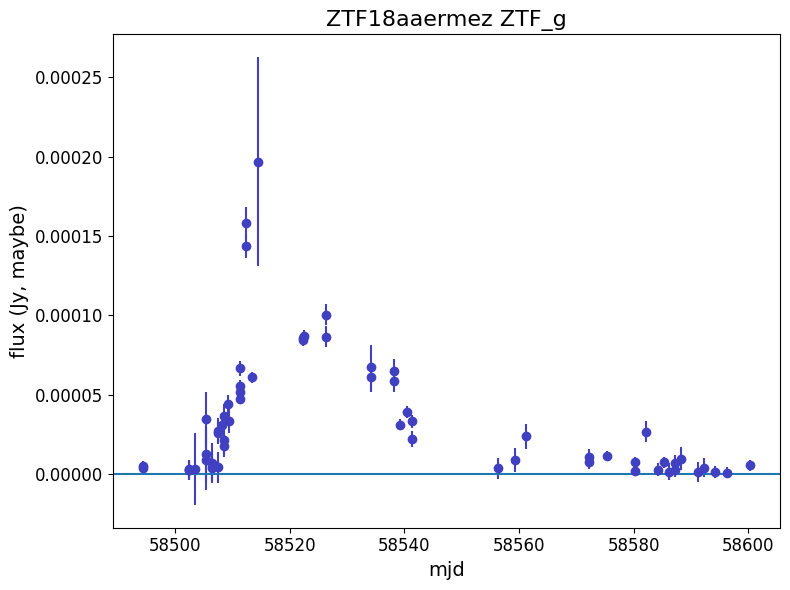

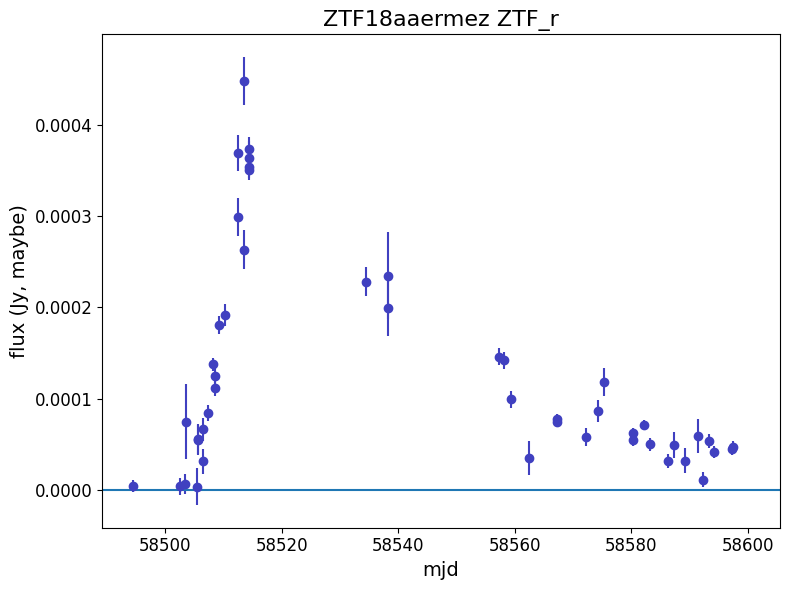

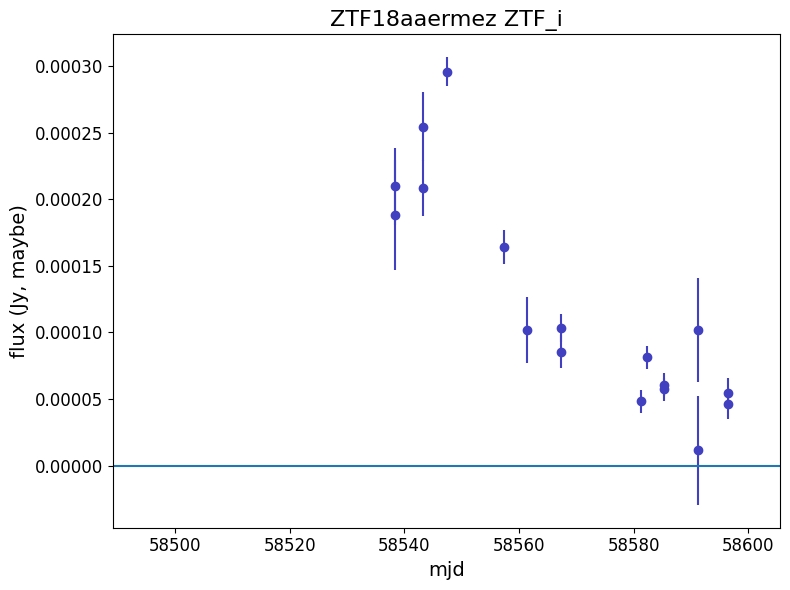

In [15]:
# Plot the lightcurves
# Plot them all with the same time range, 
#   so figure that out first

minmjd = 1e32
maxmjd = -1e32
for band in lightcurves.index.levels[0]:
    df = lightcurves.xs( band, level='band' )
    mjds = df.index.values
    if mjds.min() < minmjd: minmjd = mjds.min()
    if mjds.max() > maxmjd: maxmjd = mjds.max()

dmjd = maxmjd - minmjd
minmjd -= 0.05 * dmjd
maxmjd += 0.05 * dmjd

def plot_lightcurve( df, bandname, minmjd, maxmjd, plotparam={ 'linestyle': 'None',
                                                               'marker': 'o',
                                                               'color': '#4040c0' } ):
    fig = matplotlib.pyplot.figure( figsize=(8,6), tight_layout=True )
    ax = fig.add_subplot( 1, 1, 1 )
    ax.set_title( f"{snname} {bandname}", fontsize=16 )
    ax.set_xlabel( "mjd", fontsize=14 )
    ax.set_ylabel( "flux (Jy, maybe)", fontsize=14 )
    ax.tick_params( 'both', labelsize=12 )
    ax.errorbar( df.index.values, df['flux'], df['dflux'], **plotparam )
    ax.set_xlim( minmjd, maxmjd )
    ymin, ymax = ax.get_ylim()
    if ymin >= 0:
        ymin = - (ymax-ymin)/10.
        ax.set_ylim( ymin, ymax )
    ax.axhline( 0 )
    return fig, ax

def add_line_to_plot( ax, df, plotparam={ 'linestyle': '-', 'color': '#800000' } ):
    ax.plot( df.index.values, df['flux'], **plotparam )

# Now actually plot

for band in bands:
    df = lightcurves.xs( band.name, level='band' )
    fig, ax = plot_lightcurve( df, band.name, minmjd, maxmjd )
    fig.show()
    matplotlib.pyplot.show()
    matplotlib.pyplot.close(fig)
    

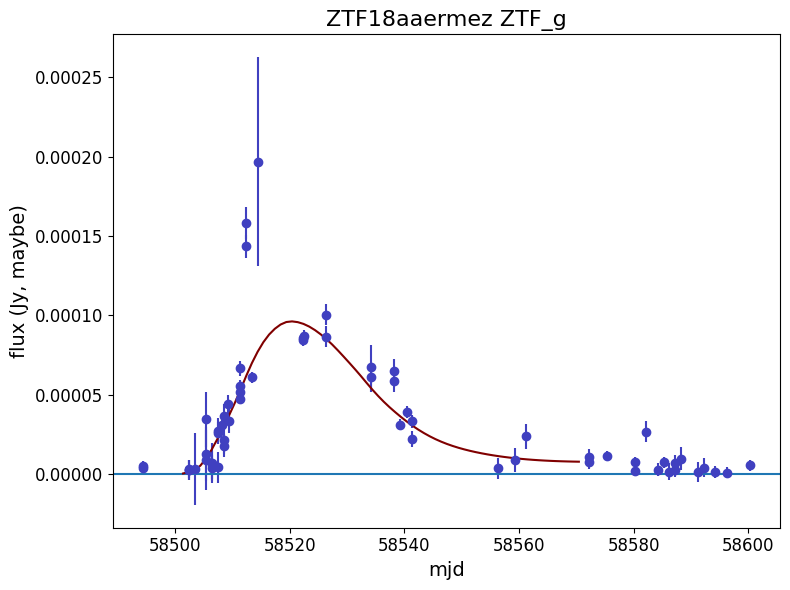

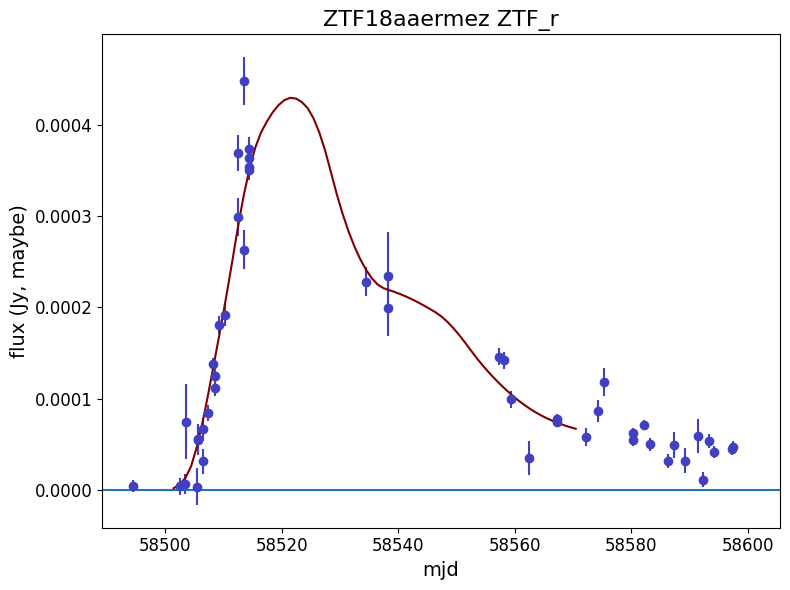

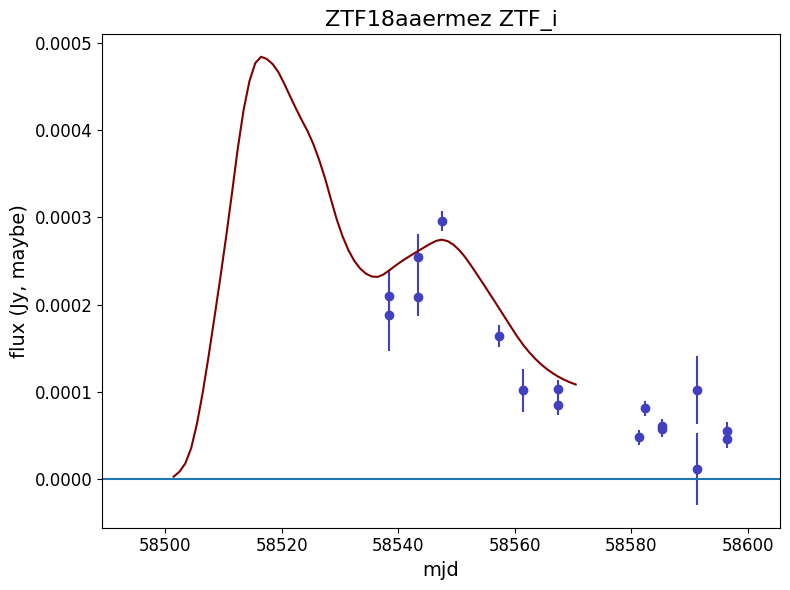

In [22]:
# Now suppose you wanted to plot a SALT2 fit on top of this.
# You can pull Salt2 fits from the database and plot them
# as follows:

# This is a map of database band names to SNCosmo band info
bandmapping = {
    'ZTF_g' : ( 'ztfg', 8.9, 'ab' ),
    'ZTF_r' : ( 'ztfr', 8.9, 'ab' ),
    'ZTF_i' : ( 'ztfi', 8.9, 'ab' ),
}

# Get a list of all SALT2 fits in the database for this supernova
# tagged with the desired versiontag
version = 'default'
salt2fit = db.Salt2Fit.get_for_obj( snname, version=version, curdb=dbo )

# Plot them on top of the data if there were any
if len(salt2fit) == 0:
    sys.stderr.write( f"No SALT2 fits tagged with {version} for {snname}" )
else:
    salt2fit = salt2fit[0]
    dust = sncosmo.CCM89Dust()
    model = sncosmo.Model( "salt2", effects=[dust], effect_names=['mw'], effect_frames=['obs'] )
    model.set( mwebv=salt2fit.mwebv )
    model.set( z=salt2fit.z )
    model.set( t0=salt2fit.t0 )
    model.set( x0=salt2fit.x0 )
    model.set( x1=salt2fit.x1 )
    model.set( c=salt2fit.c )
    ts = numpy.arange( salt2fit.t0-19, salt2fit.t0+51, 1 )

    for band in bands:
        df = lightcurves.xs( band.name, level='band' )
        fig, ax = plot_lightcurve( df, band.name, minmjd, maxmjd )

        bandinfo = bandmapping[ band.name ]
        fluxen = model.bandflux( bandinfo[0], ts, zp=bandinfo[1], zpsys=bandinfo[2] )
        fitdf = pandas.DataFrame( { 't': ts, 'flux': fluxen } ).set_index( 't' )
        add_line_to_plot( ax, fitdf )

        fig.show()
        matplotlib.pyplot.show()
        matplotlib.pyplot.close(fig)